In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import explore as e
from importlib import reload
import wrangle as w
from scipy import stats


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn.cluster import KMeans

In [2]:
reload(w)
df = w.wrangle_zillow(prop_row=.75,prop_col=.5,outlier_k=.0625)
df = df.dropna(subset=['calc_sqft','tax_value'])
train, validate, test = w.tvt_split(df)
# train.to_csv('data/prepared_zillow.csv')
df.isna().sum()

parcel_id                 0
bath_count                0
bed_count                 0
calc_bath_and_bed         0
calc_sqft                 0
fips                      0
fireplace_count           0
garage_car_count          0
latitude                  0
longitude                 0
lot_sqft                  0
pool_count                0
raw_census_tract_block    0
region_id_county          0
room_count                0
tax_value                 0
assessment_year           0
log_error                 0
transaction_date          0
dtype: int64

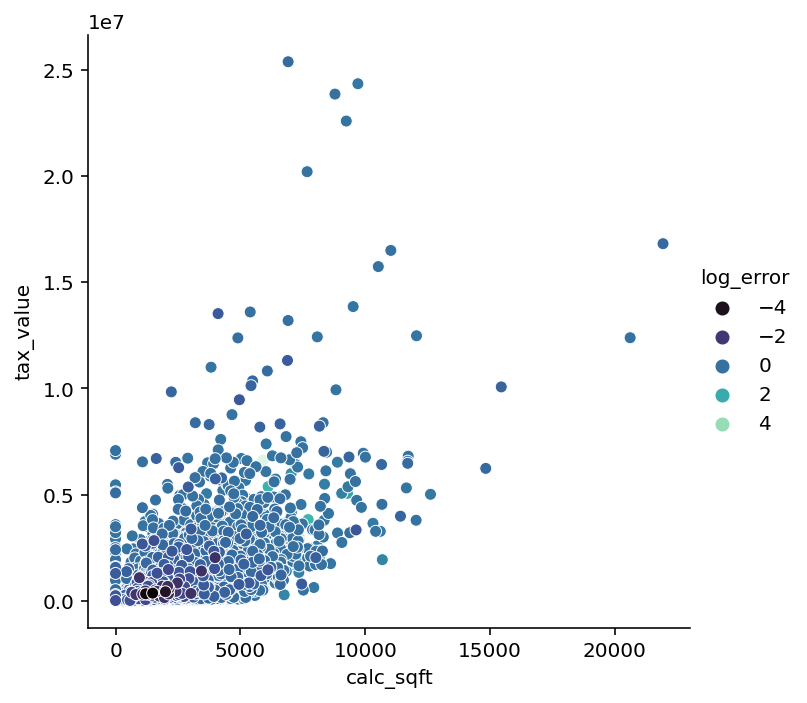

In [3]:
train.log_error = train.log_error.astype('float')
sns.relplot(data=train.sort_values('log_error',ascending=False), x='calc_sqft',y='tax_value',hue='log_error',palette='mako')

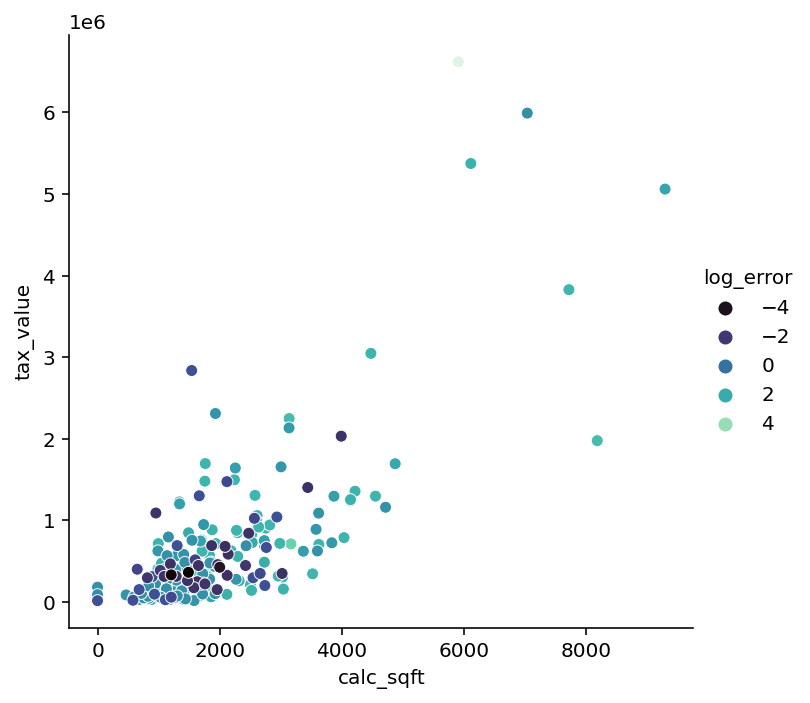

In [4]:
calc = train[((train.log_error >= 1) | (train.log_error<=-1))]
sns.relplot(data=calc.sort_values('log_error',ascending=False), x='calc_sqft',y='tax_value',hue='log_error',palette='mako')

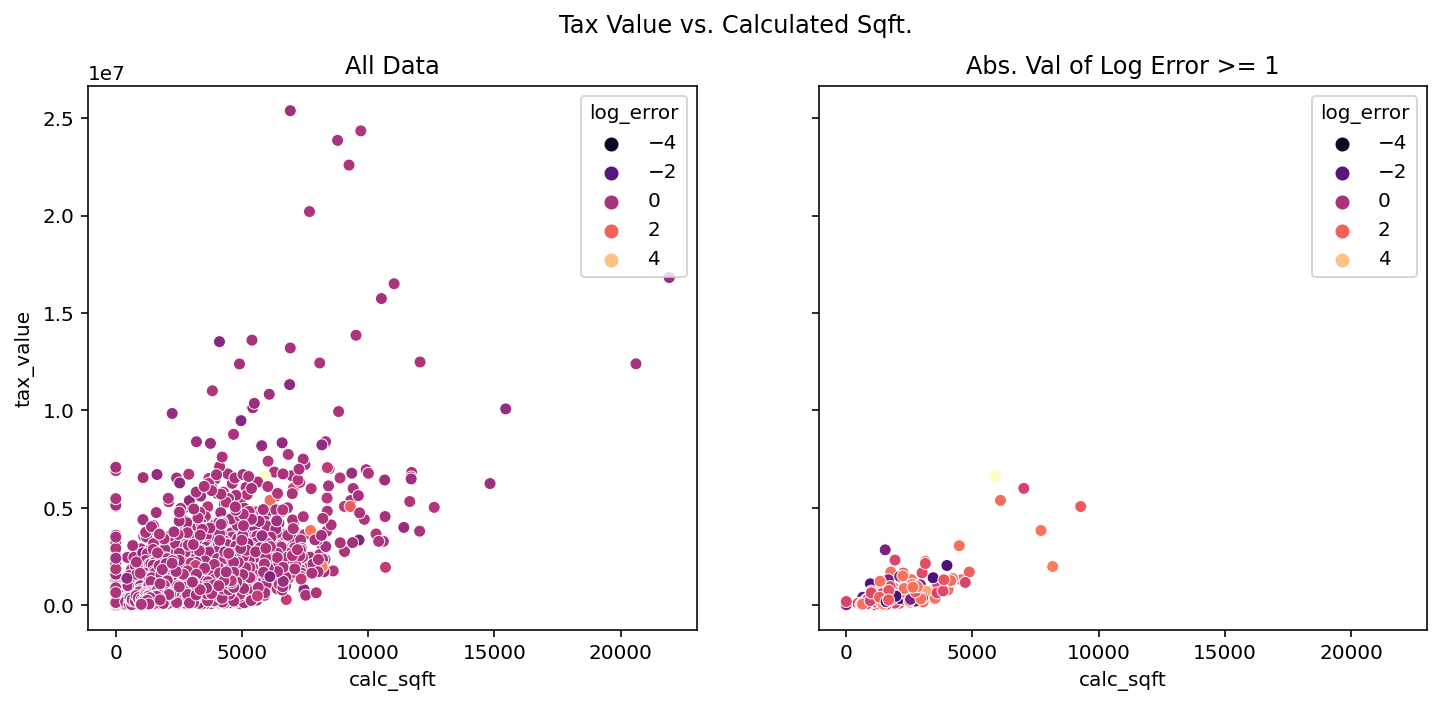

In [5]:
reload(e)
e.tax_sqft_plot(train)

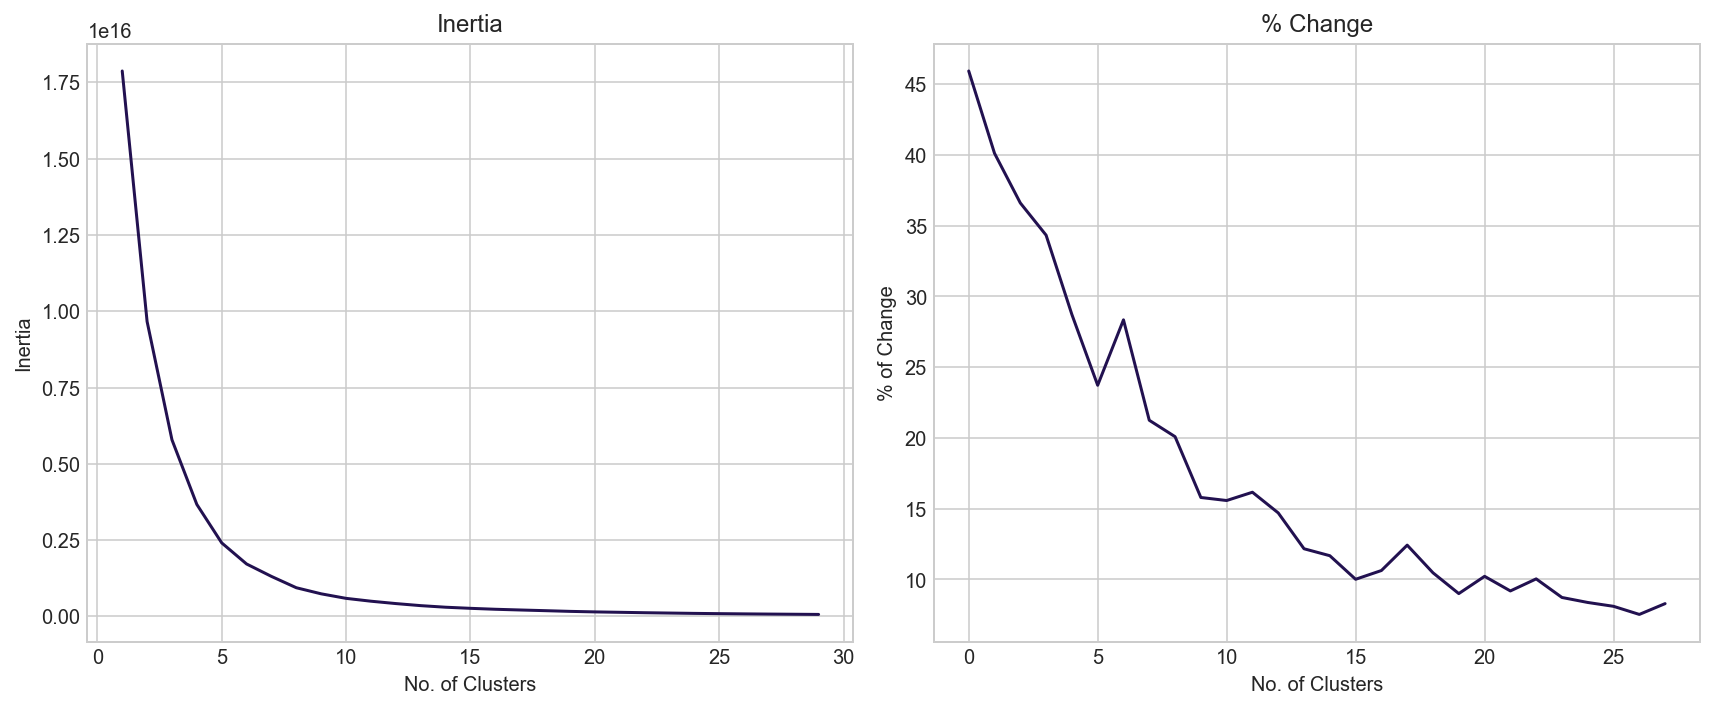

In [6]:
e.generate_elbow(train[['tax_value','calc_sqft']])

In [7]:
reload(w)
w.wrangle_zillow().isna().sum()

parcel_id                 0
bath_count                0
bed_count                 0
calc_bath_and_bed         0
calc_sqft                 0
fips                      0
fireplace_count           0
garage_car_count          0
latitude                  0
longitude                 0
lot_sqft                  0
pool_count                0
raw_census_tract_block    0
region_id_county          0
room_count                0
tax_value                 0
assessment_year           0
log_error                 0
transaction_date          0
dtype: int64

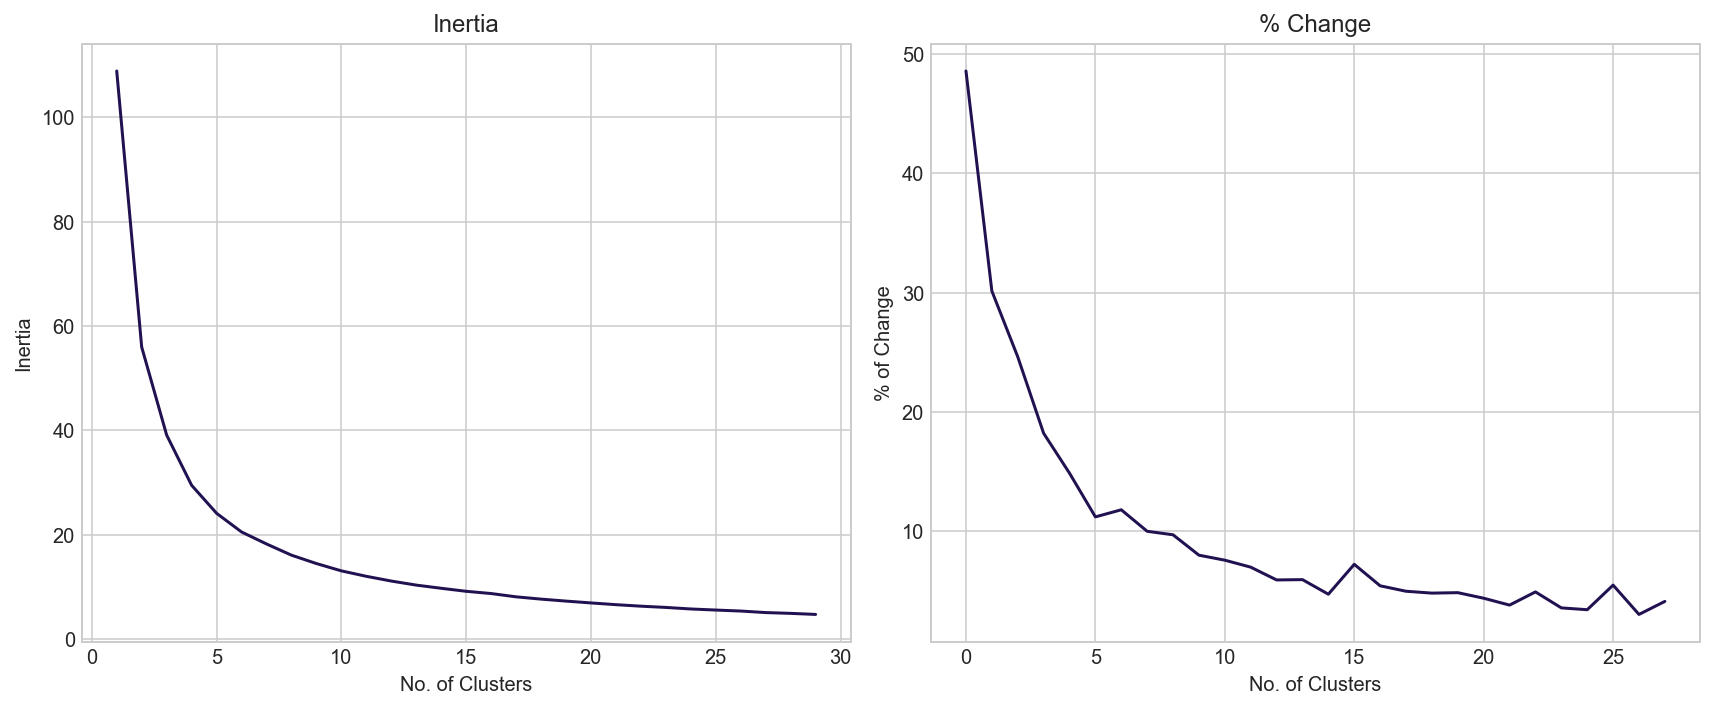

In [8]:
reload(e)
tax_sqft = w.scale(train,['tax_value','calc_sqft'])
e.generate_elbow(tax_sqft,k_min=1,k_max=30)

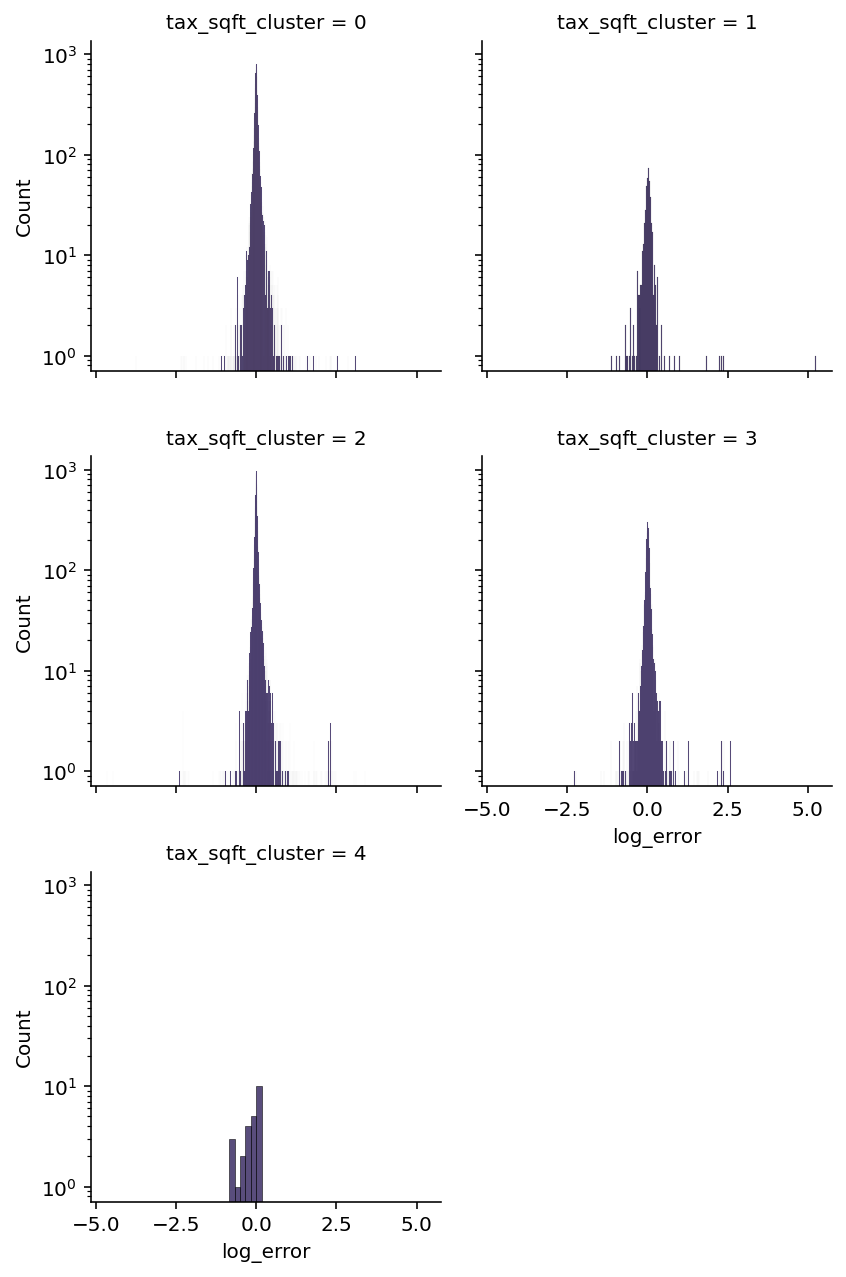

In [9]:
tax_sqft = train[['calc_sqft','tax_value','latitude','longitude']]
tax_sqft['calc_sqft'] = train['calc_sqft']
tax_sqft['tax_value'] = train['tax_value']
kmeans = KMeans(5,random_state=420)
kmeans.fit(tax_sqft)
tax_sqft['tax_sqft_cluster'] = kmeans.predict(tax_sqft)
tax_sqft['log_error'] = train.log_error
sns.set_palette('magma')
g = sns.FacetGrid(data=tax_sqft,col='tax_sqft_cluster',col_wrap=2,sharey=True,palette='mako').set(yscale='log')
g.map_dataframe(sns.histplot,x='log_error')
plt.show()

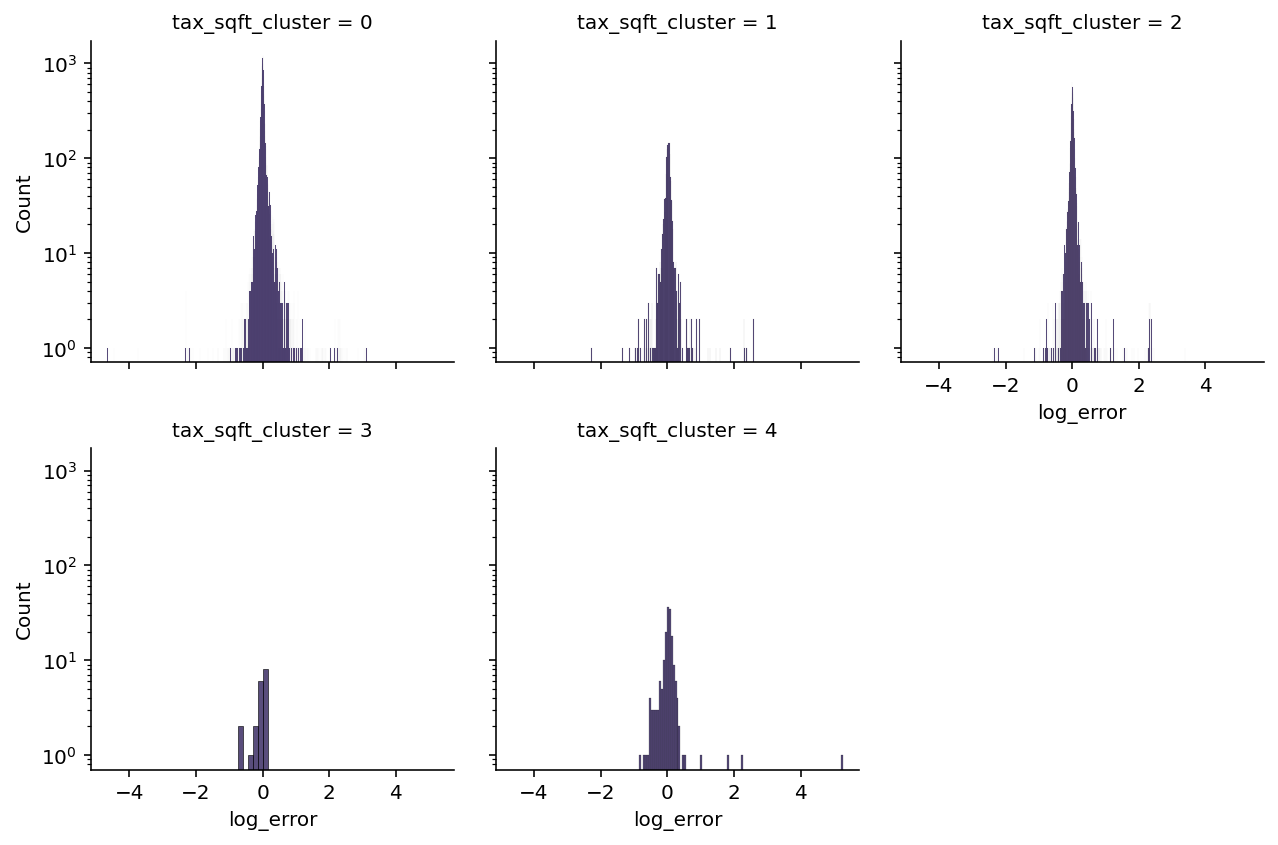

In [10]:
reload(e)
e.tax_sqft_cluster_plot(train)

Question: is the mean log_error of items clustered by tax_value and calc_sqft significantly different from each other?

$H_0$: $\mu_{taxsqft0} = \mu_{taxsqft1}=$...$\mu_{taxsqft7}$

$H_a$: $\mu_{taxsqft0} \neq \mu_{taxsqft1} \neq $...$\neq \mu_{taxsqft7}$

## Assumptions
- Independent: Yep
- Normal: yes, Central Limit Theorum
- Equal variance:

In [11]:
train['tax_sqft_cluster'] = tax_sqft.tax_sqft_cluster
train.groupby('tax_sqft_cluster').agg('var')[['log_error']]


,log_error
tax_sqft_cluster,
0,0.023433
1,0.133649
2,0.030470
3,0.051112
4,0.088235


## Nope! so we will use the non-parametric test

In [12]:
group_list = [train[train.tax_sqft_cluster == x].log_error.to_numpy() for x in range(4)]
t,p = stats.kruskal(group_list[0],group_list[1],group_list[2],group_list[3])
e.t_to_md(t,p)

## t = 2.1524926675452276e-19 

 ## p = 90.03545598023578 

## Because t > 0 and $\alpha$ < p, we failed to   reject $H_0$

<AxesSubplot:xlabel='fips', ylabel='log_error'>

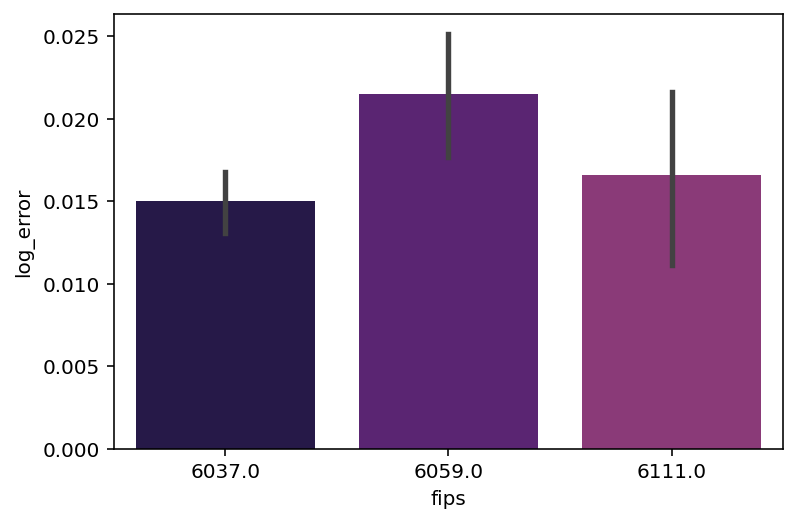

In [13]:
sns.barplot(data=train,x='fips',y='log_error')

## Does FIPS code 6059 have a significantly higher log error than the mean of the data set?

### $H_0$: $\mu_6059 = \mu_{all}$

### $H_a$: $\mu_6059 \neq \mu_{all}$


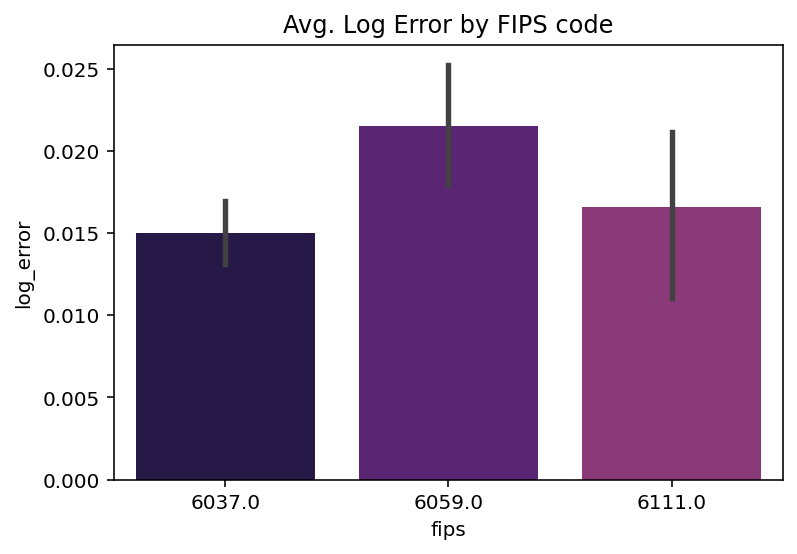

In [14]:
reload(e)
e.fips_plot(train)

In [27]:
reload(e)
e.fips_test(train)

## t = 2.5546094092223135 

 ## p/2 = 0.008041123257563827 

## Because t > 0 and $\alpha$ > p/2, we   reject $H_0$